In [1]:
library(tidyverse)
library(data.table)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
repo_dir <- '/oak/stanford/groups/mrivas/projects/PRS'

In [3]:
read_beta <- function(
    phe_name,
    task_name,
    pipeline_name = 'snpnet_biomarker_PRS',
    repo_dir = '/oak/stanford/groups/mrivas/projects/PRS'    
){    
    beta_file_name <- file.path(
        repo_dir, 'private_output', pipeline_name, task_name, '3_snpnet', paste0(phe_name, '.tsv.gz')
    )
    print(beta_file_name)
    fread(
        cmd=paste0('zcat ', beta_file_name, '| sed -e "s/^#//g"')
    )
}

In [4]:
beta_INT_df <- read_beta(
    phe_name = 'Lipoprotein_A.adjust.statins',
    task_name = 'biomarkers_20190407_INT'
)

[1] "/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_biomarker_PRS/biomarkers_20190407_INT/3_snpnet/Lipoprotein_A.adjust.statins.tsv.gz"


In [5]:
beta_df <- read_beta(
    phe_name = 'Lipoprotein_A_adjstatins',
    task_name = 'biomarkers_20190407'
)

[1] "/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_biomarker_PRS/biomarkers_20190407/3_snpnet/Lipoprotein_A_adjstatins.tsv.gz"


In [25]:
beta_joined <- beta_df %>% select(ID, BETA) %>%
full_join(
    beta_INT_df %>% select(ID, BETA) %>% rename(BETA_INT = BETA),
    by='ID'
) %>% 
replace_na(list(BETA = 0, BETA_INT = 0))  %>%
mutate(
    INT_only = (BETA == 0),
    original_only = (BETA_INT == 0),
    is_SNP_shared = if_else(
        INT_only, 'INT only (7729)',
        if_else(
            original_only, 'original only (2971)', 'captured in both (914)'
        )
    )
)

In [26]:
beta_joined %>% count(is_SNP_shared)

is_SNP_shared,n
captured in both (914),914
INT only (7729),7729
original only (2971),2971


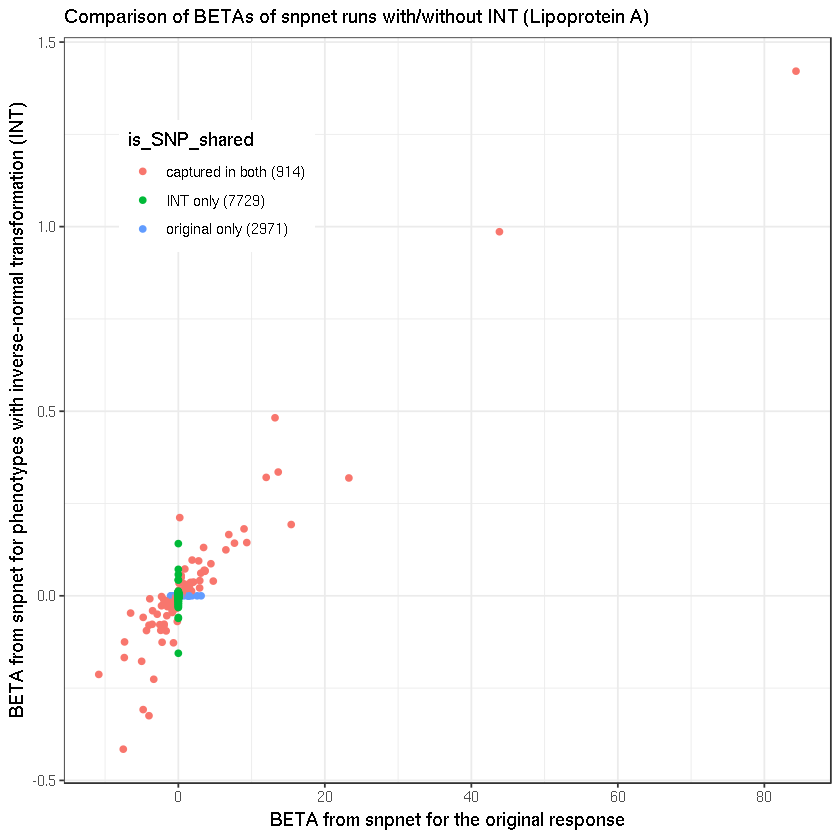

In [27]:
beta_joined %>% 
ggplot(aes(x=BETA, y=BETA_INT, color=is_SNP_shared))+ 
# geom_abline(intercept=0, slope=1, color='red') + 
# geom_abline(intercept=lm1$coefficients[1], slope=lm1$coefficients[2], 
#             color='gray', size=.5, linetype = "dashed") + 
geom_point(stat = 'identity') +
theme_bw() + 
# xlim(-max, max) + ylim(-max, max)+ 
labs(
    title = 'Comparison of BETAs of snpnet runs with/without INT (Lipoprotein A)',
    x = 'BETA from snpnet for the original response', 
    y = 'BETA from snpnet for phenotypes with inverse-normal transformation (INT)'
) + 
theme(legend.position = c(0.2, 0.8))

In [28]:
ggsave('beta_beta_comparison.LpA.png')

Saving 6.67 x 6.67 in image
